In [1]:
import pandas as pd

In [2]:
sales_long = pd.read_parquet("data/sales_long.parquet")

In [3]:
sales_long.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,...,is_weekend,is_holiday,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,price_lag_7,price_change
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,8.26,0.0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.97,0.0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,4.64,0.0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.98,0.0


### transforming StandardScaler

In [4]:
from sklearn.preprocessing import StandardScaler

sampled_df = sales_long.groupby('d', group_keys=False).apply(lambda x: x.sample(frac=0.1))


# Select features and target variable
features = ["lag_7", "lag_14", "lag_28", 
            "rolling_mean_7", "rolling_mean_14", "rolling_mean_28", 
            "day_of_week", "month", "is_weekend", "is_holiday",
            "sell_price", "price_change"]

# Extract X_train and X_val
X_train = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1, 1914)])][features]
y_train = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1, 1914)])]["sales"]

X_val = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1914, 1942)])][features]
y_val = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1914, 1942)])]["sales"]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=features, index=X_val.index)



In [5]:
sampled_df["d"].value_counts()

d
d_1       3049
d_417     3049
d_415     3049
d_414     3049
d_413     3049
          ... 
d_1586    3049
d_1585    3049
d_1584    3049
d_1583    3049
d_999     3049
Name: count, Length: 1969, dtype: int64

### Hiperparameter tunning in XGboost

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Train an XGBoost model using scaled data
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,  # Reduce learning rate
    max_depth=6,  # Reduce depth to avoid overfitting
    colsample_bytree=0.8,  # Randomly sample features for diversity
    subsample=0.8,  # Randomly sample rows
    reg_alpha=0.5,  # Increase L1 regularization to reduce noise
    reg_lambda=2.0,  # Increase L2 regularization for better generalization
    tree_method="hist",
    device="cuda",
    missing=-999
)


model.fit(X_train_scaled, y_train)  # Train on scaled data

# Validate the model
y_pred = model.predict(X_val_scaled)

# Evaluate performance
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Validation MAE: {mae:.2f}")
print(f"Validation R² Score: {r2:.2f}")


Validation MAE: 1.03
Validation R² Score: 0.66


/home/andre/.local/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [18:58:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


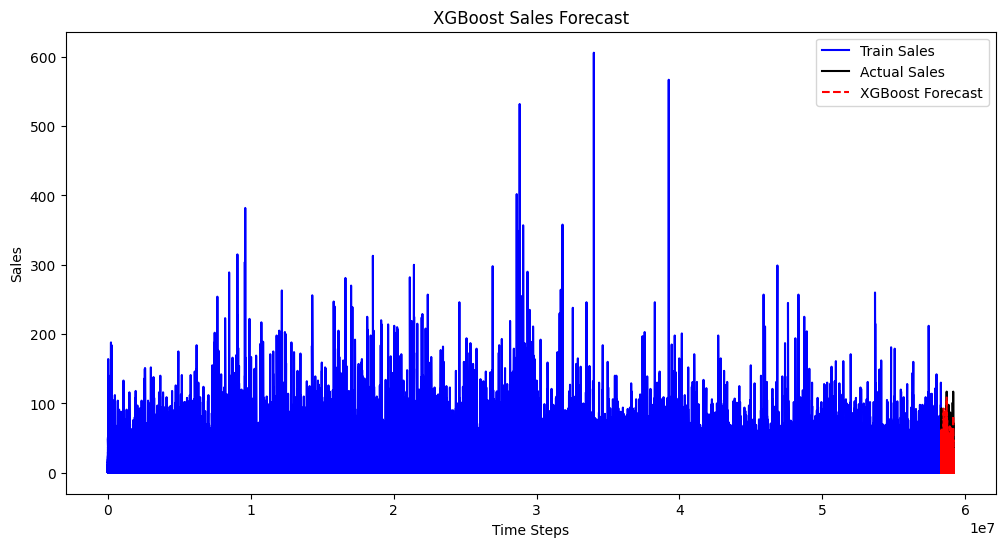

In [7]:
import matplotlib.pyplot as plt
# Get XGBoost predictions
y_pred = model.predict(X_val_scaled)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label="Train Sales", color="blue")
plt.plot(X_val_scaled.index, y_val, label="Actual Sales", color="black")
plt.plot(X_val_scaled.index, y_pred, label="XGBoost Forecast", color="red", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.title("XGBoost Sales Forecast")
plt.legend()
plt.show()

In [8]:
# Create test dataset for forecast
X_test = sales_long[sales_long["d"].isin([f"d_{i}" for i in range(1942, 1970)])][features]

# Predict sales for next 28 days
y_pred_test = model.predict(X_test)



In [9]:
y_pred_test

array([3.8318062, 1.9303038, 2.6379087, ..., 5.127668 , 6.5577216,
       7.078686 ], dtype=float32)

### Testing Arima

Test MAE: 3618.1754
Test RMSE: 4960.6790
Test R² Score: 0.3108


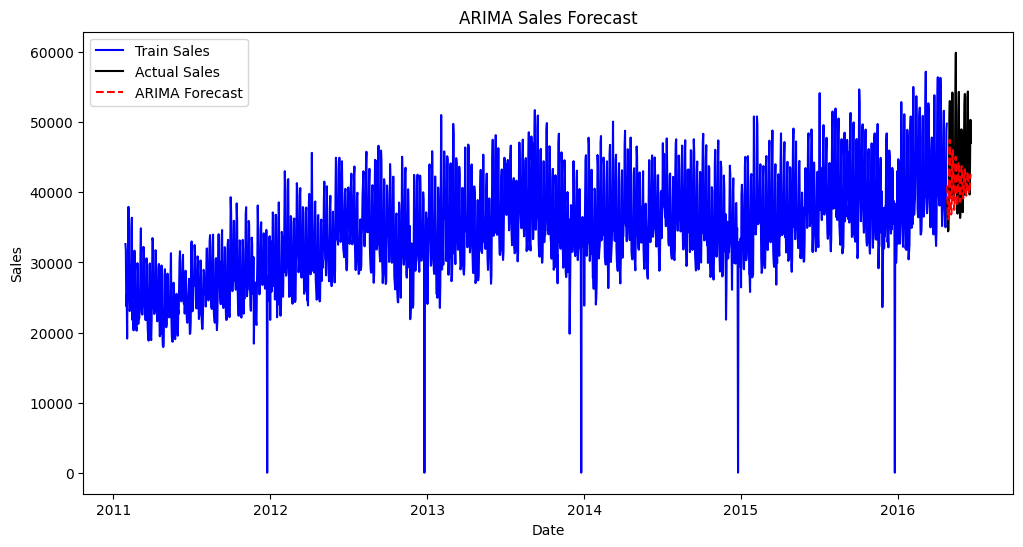

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data (using aggregated sales for a single time series)
sales_data = sales_long.groupby("date")["sales"].sum().reset_index()

# Split train/test
train = sales_data[sales_data["date"] < "2016-04-25"]  # Up to d_1913
test = sales_data[sales_data["date"] >= "2016-04-25"]  # From d_1914 onwards

# Fit ARIMA Model (p, d, q)
model = ARIMA(train["sales"], order=(7,1,0))  # Adjust p, d, q as needed
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mae = mean_absolute_error(test["sales"], forecast)
rmse = np.sqrt(mean_squared_error(test["sales"], forecast))
r2 = r2_score(test["sales"], forecast)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R² Score: {r2:.4f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train["date"], train["sales"], label="Train Sales", color="blue")
plt.plot(test["date"], test["sales"], label="Actual Sales", color="black")
plt.plot(test["date"], forecast, label="ARIMA Forecast", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("ARIMA Sales Forecast")
plt.legend()
plt.show()


### Preparing to test ExponentialSmoothing

In [11]:
# Getting a balanced sample due to a lack of a machine to use the whole with ExponentialSmoothing

sampled_df = sales_long.groupby('d', group_keys=False).apply(lambda x: x.sample(frac=0.1))

# Select features and target variable
features = ["lag_7", "lag_14", "lag_28", 
            "rolling_mean_7", "rolling_mean_14", "rolling_mean_28", 
            "day_of_week", "month", "is_weekend", "is_holiday",
            "sell_price", "price_change"]

# Extract X_train and X_val
X_train = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1, 1914)])][features]
y_train = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1, 1914)])]["sales"]

X_val = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1914, 1942)])][features]
y_val = sampled_df[sampled_df["d"].isin([f"d_{i}" for i in range(1914, 1942)])]["sales"]


/home/andre/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/andre/.local/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/andre/.local/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/andre/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/andre/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available

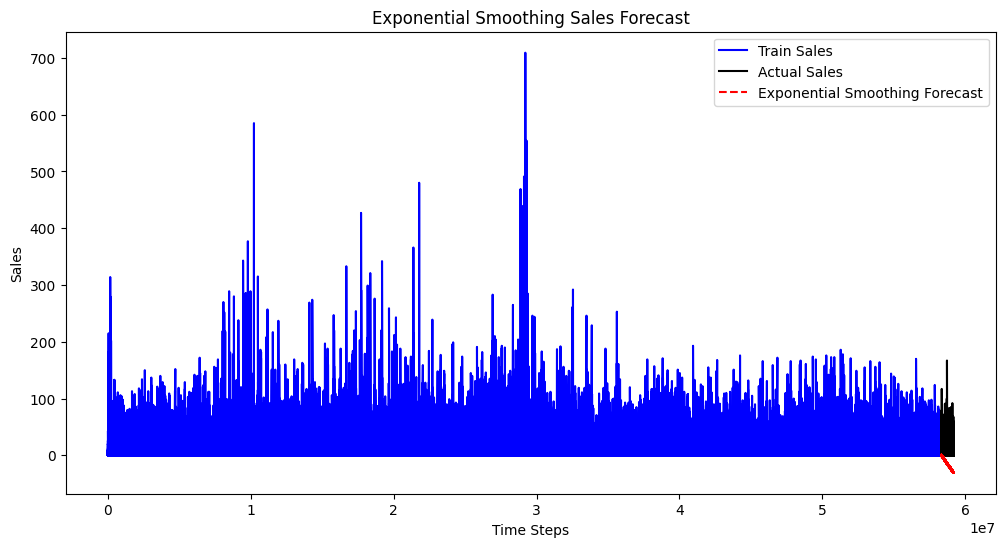

In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Exponential Smoothing model
es_model = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=7)
es_results = es_model.fit()

# Generate forecasts
y_pred_es = es_results.forecast(len(y_val))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, y_train, label="Train Sales", color="blue")
plt.plot(X_val.index, y_val, label="Actual Sales", color="black")
plt.plot(X_val.index, y_pred_es, label="Exponential Smoothing Forecast", color="red", linestyle="dashed")
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.title("Exponential Smoothing Sales Forecast")
plt.legend()
plt.show()


In [13]:
sales_long.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,...,is_weekend,is_holiday,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,price_lag_7,price_change
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,8.26,0.0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.97,0.0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,4.64,0.0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,0,0.0,0.0,0.0,0.0,0.0,0.0,2.98,0.0


### Prophet+XGBoost

In [14]:
sampled_df = sales_long.groupby('d', group_keys=False).apply(lambda x: x.sample(frac=0.1))


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
from fbprophet import Prophet

# Ensure 'ds' is datetime type
prophet_train_aggregated['ds'] = pd.to_datetime(prophet_train_aggregated['ds'])
prophet_val_aggregated['ds'] = pd.to_datetime(prophet_val_aggregated['ds'])

# Create a new Prophet model instance
model = Prophet()

# Fit the model with the training data
model.fit(prophet_train_aggregated)

# Generate a dataframe for future dates (next 28 days)
future = model.make_future_dataframe(periods=28, freq='D')

# Make predictions
forecast = model.predict(future)

# Extract only the validation period predictions
forecast_val = forecast[['ds', 'yhat']].merge(prophet_val_aggregated, on='ds', how='inner')

# Compute MAE and R²
mae = mean_absolute_error(forecast_val['y'], forecast_val['yhat'])
r2 = r2_score(forecast_val['y'], forecast_val['yhat'])

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
